Este script abre varios ficheros netCDF, lee una variable y despues calculamos cosas basicas: seleccionar una region de estudio, climatologia, anomalias y seleccionar una estacion

## Choose the kernel env_emis_gloenv39 (already created by ES)

### Add this environment to your jupyter kernel 

./installa_env39.sh

close and reopen the notebook to see the new kernel env_emis_gloenv39 and use it

### Delete the environment from your jupyter kernel
jupyter kernelspec list

jupyter kernelspec uninstall env_emis_gloenv39

In [1]:
# import xarray, numpy and pandas 
import xarray as xr
import numpy as np
import pandas as pd

import time as tm

from pylab import *

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker

import seaborn as sns

# import plotting modules 
from matplotlib.colors import BoundaryNorm
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.path as mpath

from cartopy import config
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


%matplotlib inline

/data/softs/anaconda3-2020.07/envs/gloenv_py3.9/lib/python3.9/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
## Parametres d'entree

varname = 'tas'   #'tos'
vartype = 'Amon' #! La variable nommée 'type' existe déjà dans Python, on ne souhaite pas la modifier.
model = 'CNRM-ESM2-1'
expe = 'historical' 
grid = 'gr'

fyear_in = 1850
lyear_in = 2014

fyear_out=1960 #periode de traitement pour les donnees
lyear_out=2014

#Region d'etude
# PACIFIQUE TROPICAL
#lat_bnd = [-25., 25.]
#lon_bnd = [140., 280.]
# ATLANTIQUE
lat_bnd = [20., 90.]
lon_bnd = [-90., 30.]

nbmonth = 12
month_name = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

nbseason = 4
#season = ['JFM', 'AMJ', 'JAS', 'OND']
season = ['DJF','MAM','JJA','SON']

# Plots features
#plot_type = 'png'
#plt.rcParams.update({'font.size': 20}) #augmenter la taille de la police pour toutes les figures

#Input/Output
indir = '/data/scratch/globc/dcom/CMIP6/CMIP/CNRM-CERFACS/'+model+'/'+expe+'/r*/'+vartype+'/'+varname+'/'+grid+'/latest/'
infile = varname+'_*'

outdir ='/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/'
outfile= varname+'_clim_'+model+'_'+expe+'_'+grid+'_'+str(fyear_out)+'01-'+str(lyear_out)+'12.nc'
#figdir = outdir
#figfile = 'plot2D_clim_'+varname+'_'+expe+'_'+str(fyear_out)+'_'+str(lyear_out)


In [3]:
#Lecture du fichier
ds = xr.open_mfdataset(indir+infile,engine='netcdf4', concat_dim='ensemble', combine='nested', chunks={'time': 1980})
#ds.info() #youpiiii!
fld = ds[varname]
#fld

In [4]:
# -- On calcule la moyenne de l'ensemble
#fld_emean = fld.mean('ensemble').compute()
#fld_emean
# -- On laisse cela pour la fin car d'abord il faut calculer la STD pour chaque membre

In [5]:
# -- On selectionne une periode de temps
fld_sel = fld.sel(time=slice(str(fyear_out)+'-01-01', str(lyear_out)+'-12-31'))
fld_sel

<xarray.DataArray 'tas' (ensemble: 10, time: 660, lat: 128, lon: 256)>
dask.array<getitem, shape=(10, 660, 128, 256), dtype=float32, chunksize=(1, 660, 128, 256), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    height   float64 2.0
  * time     (time) datetime64[ns] 1960-01-16T12:00:00 ... 2014-12-16T12:00:00
Dimensions without coordinates: ensemble
Attributes:
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       air_temperature
    description:         Near-Surface Air Temperature
    long_name:           Near-Surface Air Temperature
    history:             none
    units:               K
    cell_measures:       area: areacella

In [6]:
# -- On selectionne la region d'etude
# -- Si c'est dans l'Atlantique, on est oblige de faire un lonflip, autrement on ne fait rien
# Dans ce cas on est obliges de shifter les longitudes (lonFlip)
fld_sel =  fld.assign_coords(lon=(((fld.lon + 180) % 360) - 180)).sortby('lon')
fld_sel_dom = fld_sel.sel(lon=slice(*lon_bnd), lat=slice(*lat_bnd)) #Maintenant c'est OK
fld_sel_dom

/data/softs/anaconda3-2020.07/envs/gloenv_py3.9/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray 'tas' (ensemble: 10, time: 1980, lat: 50, lon: 86)>
dask.array<getitem, shape=(10, 1980, 50, 86), dtype=float32, chunksize=(1, 1980, 50, 86), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 20.31 21.71 23.11 24.51 ... 84.74 86.14 87.54 88.93
  * lon      (lon) float64 -90.0 -88.59 -87.19 -85.78 ... 26.72 28.12 29.53
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Dimensions without coordinates: ensemble
Attributes:
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       air_temperature
    description:         Near-Surface Air Temperature
    long_name:           Near-Surface Air Temperature
    history:             none
    units:               K
    cell_measures:       area: areacella

In [7]:
# -- On calcule la climatologie 12 mois
fld_clm = fld_sel_dom.groupby('time.month').mean('time')
fld_clm = fld_clm - 273.15
lons = fld_clm.lon.values
lats = fld_clm.lat.values
fld_clm_emean = fld_clm.mean('ensemble').compute()

In [8]:
# -- On calcule la std  climatologique 12 mois
fld_std = fld_sel_dom.groupby('time.month').std("time")
fld_std_emean = fld_std.mean('ensemble').compute()

In [9]:
# -- Define functions to plot the climatology 
# -- On define une fonction pour le plot

latS=lat_bnd[0]
latN=lat_bnd[1]
lonW=lon_bnd[0]
lonE=lon_bnd[1]

projection = ccrs.Orthographic(central_longitude=(lonW+lonE)/2., central_latitude=(latS+latN)/2.)

def make_boundary_path(lon,lat):
    lons,lats=np.meshgrid(lon,lat)
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],lats[1,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,1],lats[:,1]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

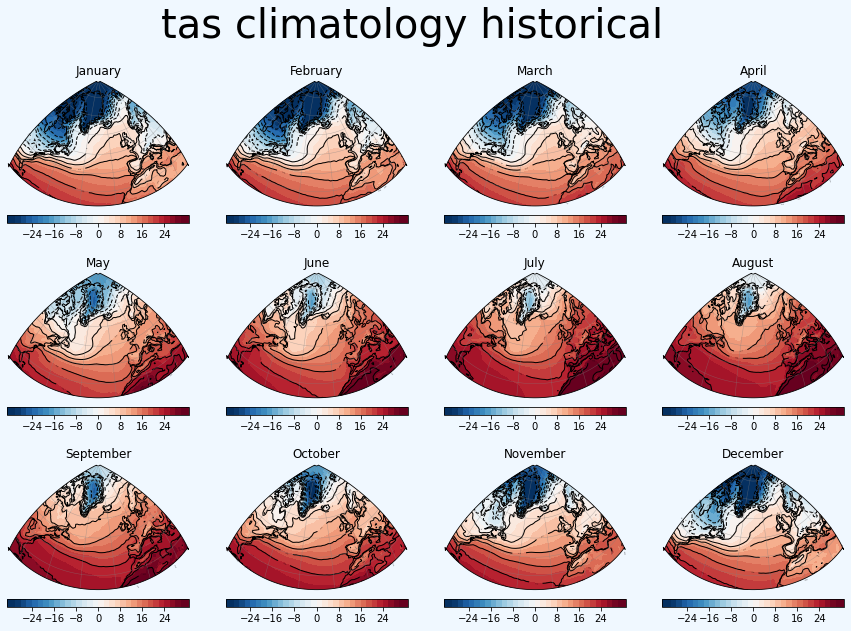

In [10]:
# -- On fait le plots pour la clim

fig = plt.figure(figsize=(15, 10),  facecolor='aliceblue')
fig.suptitle(varname+' climatology '+expe, fontsize=40)
for i in range(nbmonth):
    ax = fig.add_subplot(3,4,i+1, projection=projection)
    ax.set_title(month_name[i], loc='center')
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='grey', alpha=0.5, linestyle='-')
    boundary_path = make_boundary_path(lons, lats)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    cf = ax.contourf(lons, lats, fld_clm_emean[i],  np.linspace(-30, 30, 31), transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both')
    c = ax.contour(lons, lats, fld_clm_emean[i], np.linspace(-30, 30, 16), colors='black', linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(c, inline=1, fmt='%4.0f', fontsize=2)
    cb = fig.colorbar(cf, orientation='horizontal', aspect=20, shrink=1, pad=0.05, extendrect='True')
    
    ## Autres options
    #cf = ax.contourf(lons, lats, regime, np.linspace(-14, 14, 15),
     #                cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
    #c = ax.contour(lons, lats, regime, np.linspace(-14, 14, 15), colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    #ax.clabel(c, inline=1, fmt='%4.0f', fontsize=10)
    #cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')
    #cb.set_label('Anomaly (hPa)', fontsize=12)

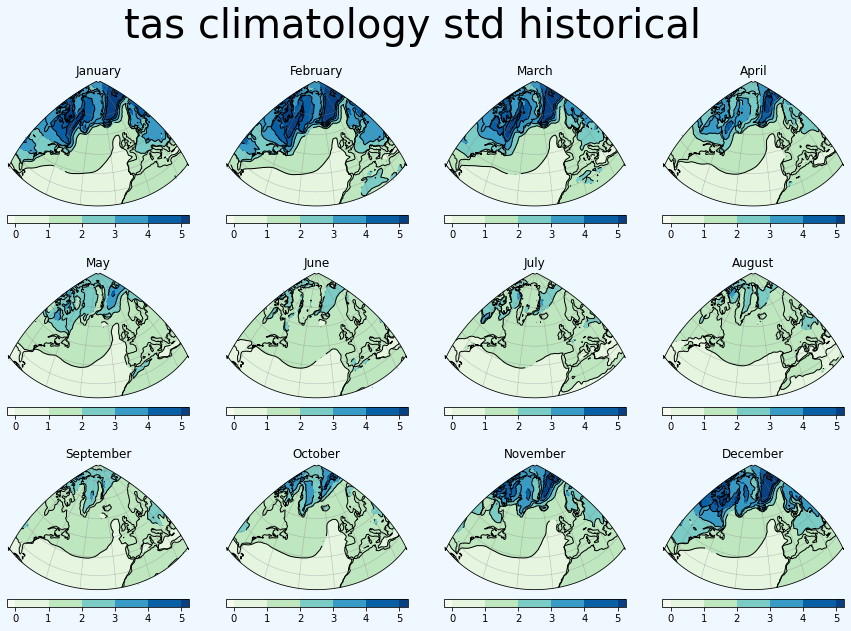

In [11]:
# -- On fait le plots pour la clim-std

fig = plt.figure(figsize=(15, 10),  facecolor='aliceblue')
fig.suptitle(varname+' climatology std '+expe, fontsize=40)
for i in range(nbmonth):
    ax = fig.add_subplot(3,4,i+1, projection=projection)
    ax.set_title(month_name[i], loc='center')
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='grey', alpha=0.5, linestyle='-')
    boundary_path = make_boundary_path(lons, lats)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    cf = ax.contourf(lons, lats, fld_std_emean[i],  np.linspace(0, 5, 6), transform=ccrs.PlateCarree(), cmap='GnBu', extend='both')
    c = ax.contour(lons, lats, fld_std_emean[i], np.linspace(0, 5, 6), colors='black', linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(c, inline=1, fmt='%4.0f', fontsize=2)
    cb = fig.colorbar(cf, orientation='horizontal', aspect=20, shrink=1, pad=0.05, extendrect='True')


In [12]:
## - On garde tout dans un fichier netCDF
ds = xr.Dataset({'fld_clm': fld_clm, 'fld_std':fld_std},
                attrs = {
                    'creation_date': tm.strftime('%d/%m/%Y'),
                    'script_name': 'compute_ClimStd_2D_1file_atmos.ipynb',
                })
    
output  = outdir + outfile
ds.to_netcdf(output)